<a href="https://colab.research.google.com/github/Yeonsu-Hong/Aiffel_Daegu_AI_project/blob/master/Going_Deeper_10_segmentation_model_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
# 10-5. 프로젝트 : 개선된 U-Net 모델 만들기

**1. 필요한 라이브러리를 불러오고 사전작업**

In [58]:
!mkdir -p ~/aiffel/semantic_segmentation/data

In [59]:
# Python 모듈 설치 확인
!pip list | grep albumentations

albumentations                0.1.12


In [60]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
data_dir = 'drive/MyDrive/Colab Notebooks/aiffel_data/Going_deeper/Going_deeper_10_segmentation_model/data'

train_path = os.path.join(data_dir, 'training')
test_path = os.path.join(data_dir, 'testing')

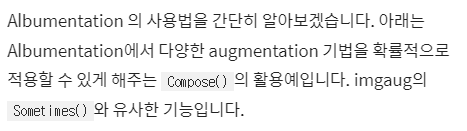

**2. Albumentation 사용하여 데이터 전처리**

In [63]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

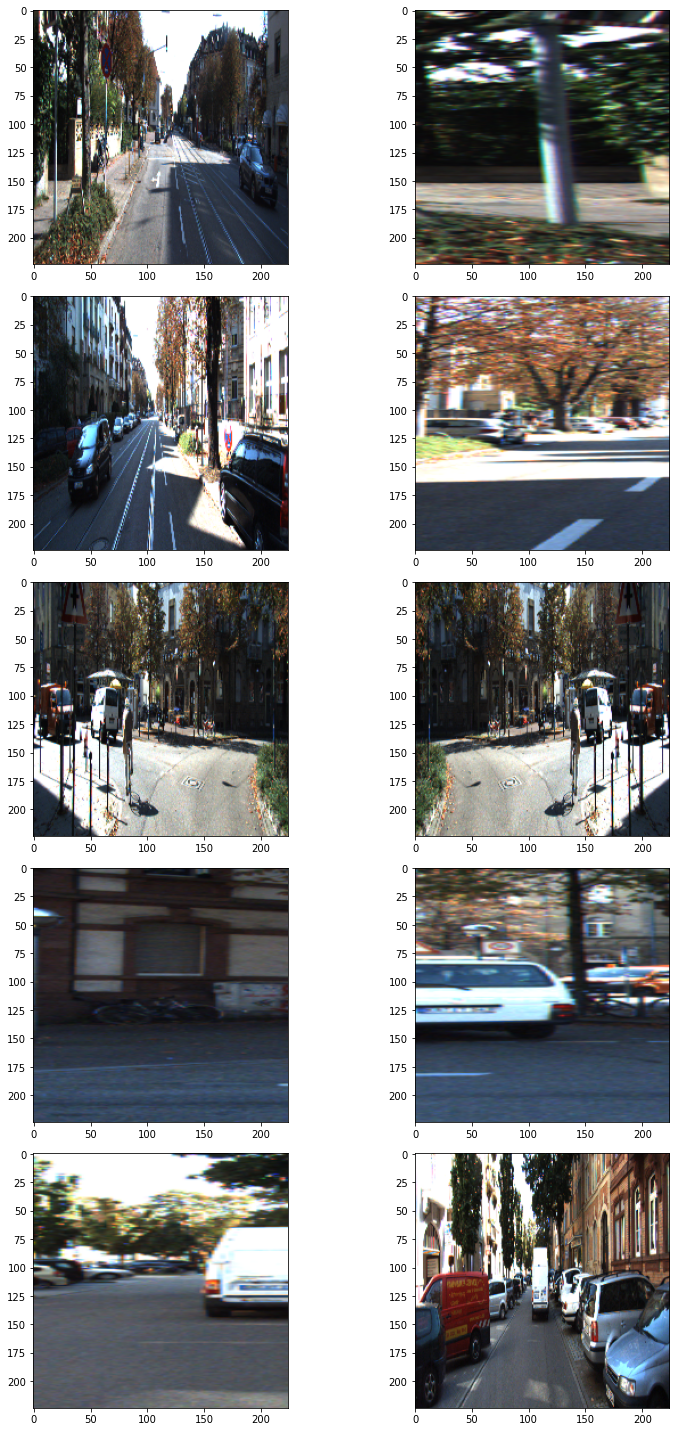

In [64]:
augmentation = build_augmentation()

input_images = glob(os.path.join(train_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지

plt.tight_layout()
plt.show()

**3. tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터를 구성해 보자!**

In [65]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               train_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.train_path = train_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.train_path = train_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.train_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.train_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [66]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    train_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    train_path, 
    augmentation=test_preproc,
    is_train=False
)

**4. semantic segmentation 모델 (U-Net 구현)**

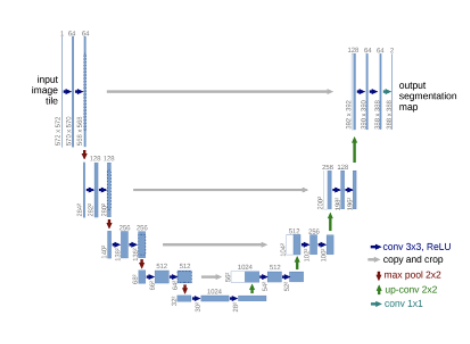

segmentation 모델 중 구조상 비교적 구현이 단순한 U-Net을 구현해보자.

입력 이미지의 크기는 위에서 만든 데이터셋에 맞춰서 만들고

필요에 따라서 Dropout등의 다른 레이어를 적용

- Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

In [67]:
def build_model(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)
	
  #Contracting Path
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
  
  #Expanding Path
  drop5 = Dropout(0.5)(conv5)
  up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
  up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
  up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

In [68]:
unet = build_model()
unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_61 (Conv2D)             (None, 224, 224, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_62 (Conv2D)             (None, 224, 224, 64  36928       ['conv2d_61[0][0]']              
                                )                                                           

모델 학습하기

위에서 만들어본 데이터셋과 학습을 해보자.

In [69]:
unet.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')

In [70]:
unet.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100
 )

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


11/11 [==============================] - 5s 352ms/step - loss: 0.6949 - val_loss: 0.6876
Epoch 2/100
11/11 [==============================] - 4s 324ms/step - loss: 0.6813 - val_loss: 0.6661
Epoch 3/100
11/11 [==============================] - 4s 326ms/step - loss: 0.4970 - val_loss: 0.0510
Epoch 4/100
11/11 [==============================] - 4s 331ms/step - loss: 0.0346 - val_loss: 0.0395
Epoch 5/100
11/11 [==============================] - 4s 323ms/step - loss: 0.0305 - val_loss: 0.0386
Epoch 6/100
11/11 [==============================] - 4s 322ms/step - loss: 0.0287 - val_loss: 0.0327
Epoch 7/100
11/11 [==============================] - 4s 322ms/step - loss: 0.0209 - val_loss: 0.0295
Epoch 8/100
11/11 [==============================] - 4s 323ms/step - loss: 0.0221 - val_loss: 0.0257
Epoch 9/100
11/11 [==============================] - 4s 323ms/step - loss: 0.0203 - val_loss: 0.0264
Epoch 10/100
11/11 [==============================] - 4s 323ms/step - loss: 0.0247 - val_loss: 0.0240
E

In [71]:
data_dir = 'drive/MyDrive/Colab Notebooks/aiffel_data/Going_deeper/Going_deeper_10_segmentation_model/data'

In [72]:
unet_path = 'drive/MyDrive/Colab Notebooks/aiffel_data/Going_deeper/Going_deeper_10_segmentation_model/data/training/seg_model_unet.h5'
unet.save(unet_path)  # 학습한 모델을 저장하기.

**5. semantic segmentation 모델 시각화**

In [73]:
# 미리 준비한 모델을 불러오려면 아래 주석을 해제하라.
# model_path = dir_path + '/seg_model_unet.h5'   # 주석을 풀 필요가 없음. 위에서 학습시켰으니까

model = tf.keras.models.load_model(unet_path)

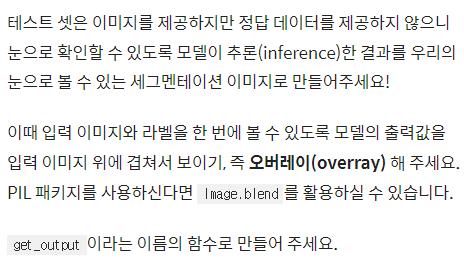

In [74]:

def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output 

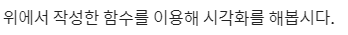

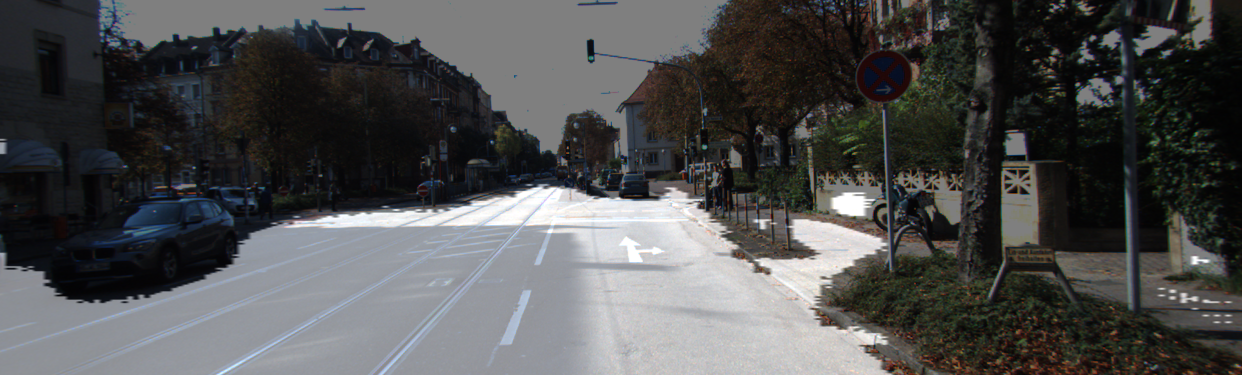

In [75]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=train_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=train_path + f'./result_{str(i).zfill(3)}.png'
 )

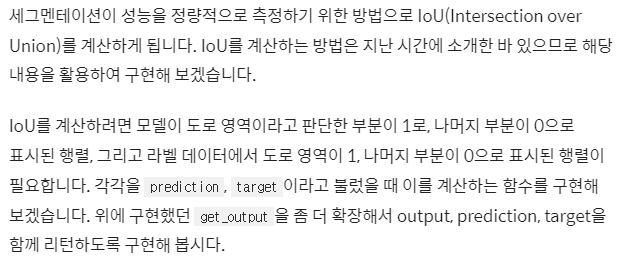

In [76]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [77]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [78]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=train_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=train_path + f'./result_{str(i).zfill(3)}.png',
     label_path=train_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.892138


0.892138133725202

# 본격 프로젝트 시작

링크는 프로젝트 아닌 본 파일에 있음

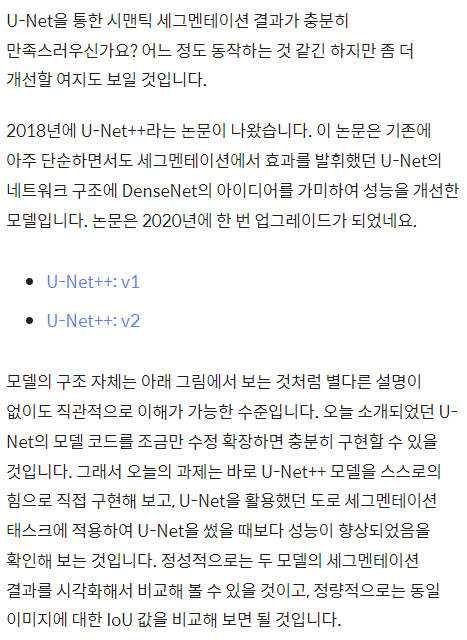

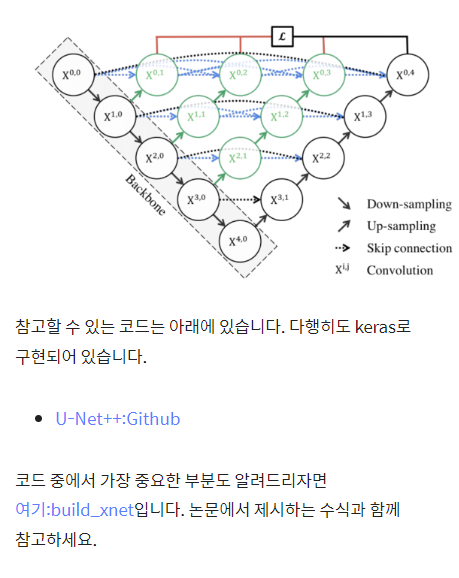

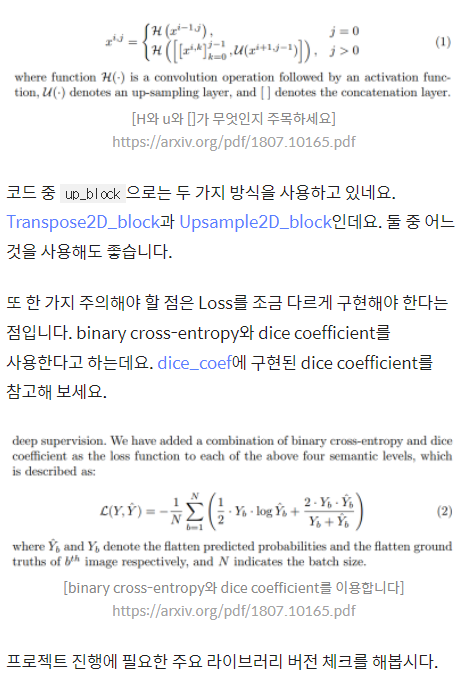

참조** [U-Net++ 논문 리뷰](https://wsshin.tistory.com/2) -> 파이토치로 구현 되어 있음

U-Net++와 U-Net과의 차이점

1. Re-designed skip pathways : U-Net에서도 skip-connection을 해주는 부분이 있었지만, U-Net++에서는 DenseNet의 아이디어를 차용하여 Encoder(수축경로)와 Decoder(확장 경로)사이의 semantic(의미적) Gap을 연결시켜 준다.

2. Deep Supervision : 각 브랜치의 출력 (빨간색 선으로 표시된 부분)을 평균해서 최종 결과로서 사용하는 방법

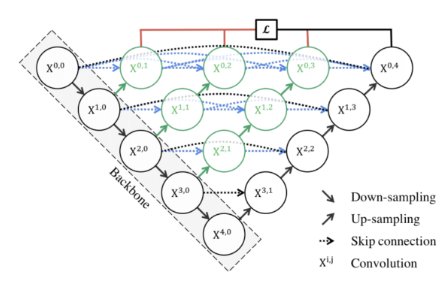

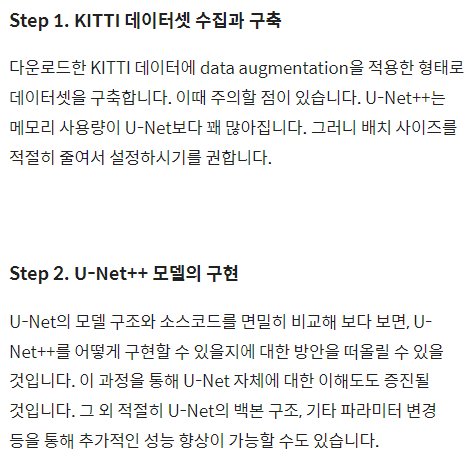

In [79]:
# U-Net++ 모델 함수로 생성
def build_unet_pp(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    
    # X0,0
    conv0_0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv0_0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_0)
    pool0_0 = MaxPooling2D(pool_size=(2, 2))(conv0_0)
    # X1,0
    conv1_0 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool0_0)
    conv1_0 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_0)
    pool1_0 = MaxPooling2D(pool_size=(2, 2))(conv1_0)
    # X2,0
    conv2_0 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1_0)
    conv2_0 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_0)
    pool2_0 = MaxPooling2D(pool_size=(2, 2))(conv2_0)
    # X3,0
    conv3_0 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2_0)
    conv3_0 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_0)
    pool3_0 = MaxPooling2D(pool_size=(2, 2))(conv3_0)
    # X4,0
    conv4_0 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3_0)  
    conv4_0 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4_0)

    # X0,1
    up1_0 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv1_0)) 
    merge0_1 = concatenate([up1_0, conv0_0], axis = 3)
    conv0_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_1)
    conv0_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_1)
    # X1,1
    up2_0 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_0))
    merge1_1 = concatenate([up2_0, conv1_0], axis = 3)
    conv1_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_1)
    conv1_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_1)
    # X2,1
    up3_0 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3_0))
    merge2_1 = concatenate([up3_0, conv2_0], axis = 3)
    conv2_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_1)
    conv2_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_1)
    # X3,1
    up4_0 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv4_0))
    merge3_1 = concatenate([up4_0, conv3_0], axis = 3)
    conv3_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge3_1)
    conv3_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_1)  
    
    # X0,2
    up1_1 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv1_1)) 
    merge0_2 = concatenate([up1_1, conv0_0, conv0_1], axis = 3)
    conv0_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_2)
    conv0_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_2)
    # X1,2
    up2_1 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_1))
    merge1_2 = concatenate([up2_1, conv1_0, conv1_0], axis = 3)
    conv1_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_2)
    conv1_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_2)
    # X2,2
    up3_1 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3_1))
    merge2_2 = concatenate([up3_1, conv2_0, conv2_1], axis = 3)
    conv2_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_2)
    conv2_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_2)

    # X0,3
    up1_2 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv1_2)) 
    merge0_3 = concatenate([up1_2, conv0_0, conv0_1, conv0_2], axis = 3)
    conv0_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_3)
    conv0_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_3)
    # X1,3
    up2_2 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_2))
    merge1_3 = concatenate([up2_2, conv1_0, conv1_1, conv1_2], axis = 3)
    conv1_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_3)
    conv1_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_3)
    
    # X0,4
    up1_3 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv1_3)) 
    merge0_4 = concatenate([up1_3, conv0_0, conv0_1, conv0_2, conv0_3], axis = 3)
    conv0_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge0_4)
    conv0_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv0_4)
    
    output = Conv2D(1, 1, activation='sigmoid')(conv0_4)
    model = Model(inputs = inputs, outputs = output)
    
    return model

In [80]:
unet_pp = build_unet_pp()
unet_pp.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_81 (Conv2D)             (None, 224, 224, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_82 (Conv2D)             (None, 224, 224, 64  36928       ['conv2d_81[0][0]']              
                                )                                                           

In [81]:
unet_pp.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')

In [82]:
unet_pp.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


11/11 [==============================] - 16s 1s/step - loss: 0.6693 - val_loss: 0.5919
Epoch 2/100
11/11 [==============================] - 13s 1s/step - loss: 0.2247 - val_loss: 0.0346
Epoch 3/100
11/11 [==============================] - 13s 1s/step - loss: 0.0271 - val_loss: 0.0278
Epoch 4/100
11/11 [==============================] - 13s 1s/step - loss: 0.0296 - val_loss: 0.0306
Epoch 5/100
11/11 [==============================] - 13s 1s/step - loss: 0.0286 - val_loss: 0.0284
Epoch 6/100
11/11 [==============================] - 13s 1s/step - loss: 0.0243 - val_loss: 0.0292
Epoch 7/100
11/11 [==============================] - 13s 1s/step - loss: 0.0240 - val_loss: 0.0279
Epoch 8/100
11/11 [==============================] - 13s 1s/step - loss: 0.0183 - val_loss: 0.0260
Epoch 9/100
11/11 [==============================] - 13s 1s/step - loss: 0.0303 - val_loss: 0.0422
Epoch 10/100
11/11 [==============================] - 13s 1s/step - loss: 0.0257 - val_loss: 0.0234
Epoch 11/100
11/11 [=

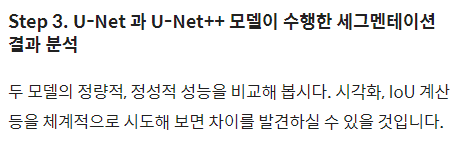

In [83]:
# data_dir = 'drive/MyDrive/Colab Notebooks/aiffel_data/Going_deeper/Going_deeper_10_segmentation_model/data'

# train_path = os.path.join(data_dir, 'training')
# test_path = os.path.join(data_dir, 'testing')

In [84]:
# unet_path = 'drive/MyDrive/Colab Notebooks/aiffel_data/Going_deeper/Going_deeper_10_segmentation_model/data/training/seg_model_unet.h5'
# unet = tf.keras.models.load_model(unet_path)

In [85]:
unet_pp_path = 'drive/MyDrive/Colab Notebooks/aiffel_data/Going_deeper/Going_deeper_10_segmentation_model/data/training/seg_model_unet_pp.h5'
unet_pp.save(unet_pp_path)  # 새롭게 학습된 U-Net++ 모델 저장

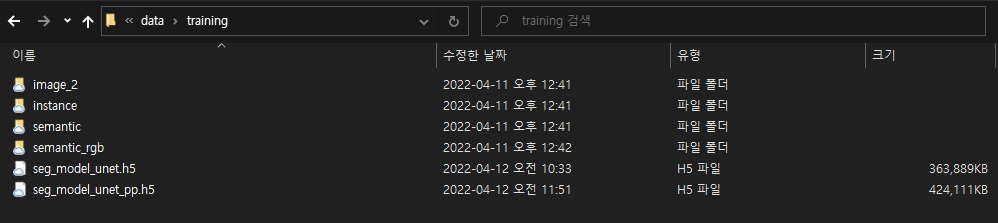

저장된 것을 확인

In [86]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  # 0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output

U-Net 시각화! --> 학습 노드해서 했던것 재탕

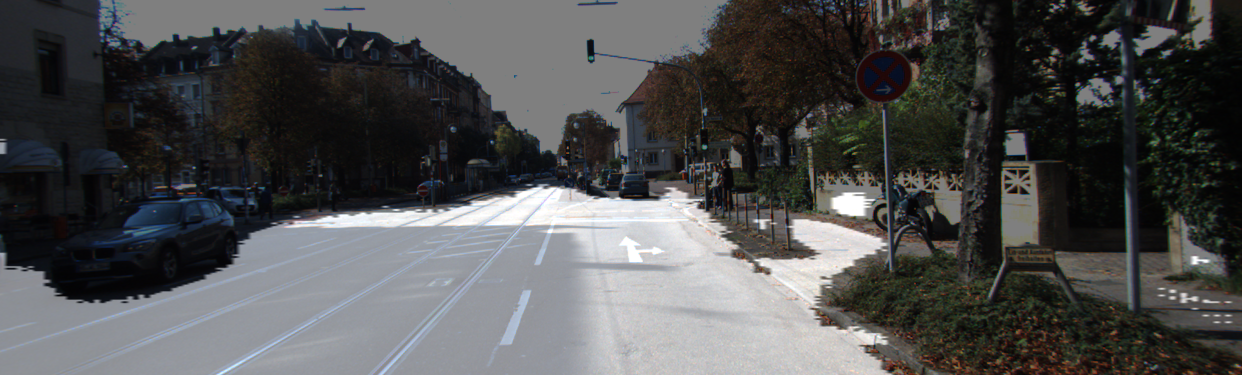

In [87]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=train_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=train_path + f'./result_{str(i).zfill(3)}.png'
 )

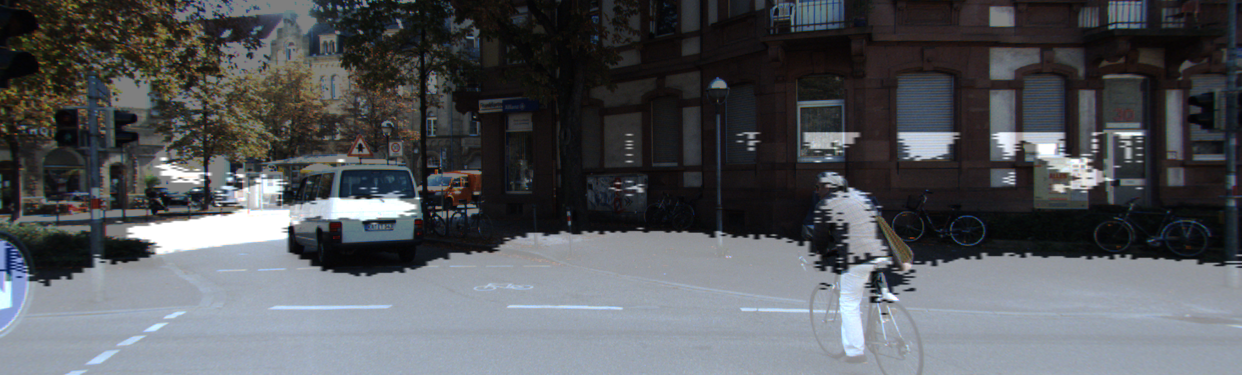

In [88]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 2    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=train_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=train_path + f'./result_{str(i).zfill(3)}.png'
 )

U-Net++ 시각화! 

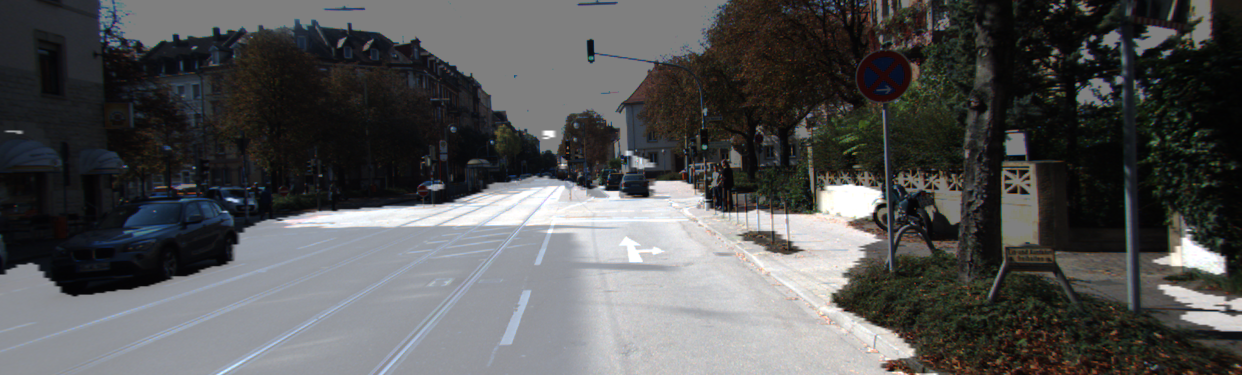

In [89]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     unet_pp,  # unet++ 
     test_preproc,
     image_path=train_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=train_path + f'./result_{str(i).zfill(3)}.png'
 )

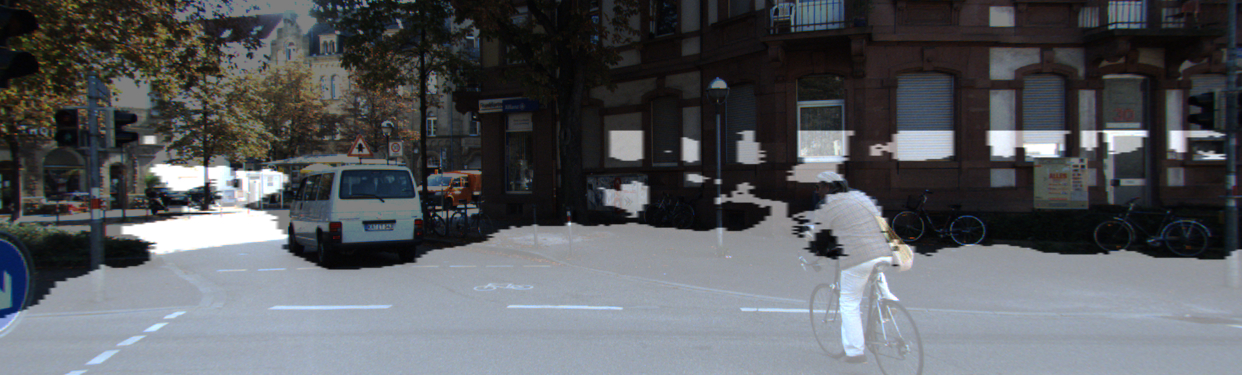

In [90]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 2    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     unet_pp,  # unet++ 
     test_preproc,
     image_path=train_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=train_path + f'./result_{str(i).zfill(3)}.png'
 )

한눈에 봐도 U-net++이 더 나아 보인다.

## 좀더 정량적인 분석을 위해 IoU(Intersection over Union)을 가져온다.



In [91]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )

    return iou_score

In [92]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [93]:
unet_iou = []
unet_pp_iou = []

for i in range(200):  # 이미지 200개로 테스트
    # U-Net의 IoU 계산
    output, prediction, target = get_output(
         unet, 
         test_preproc,
         image_path=train_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=train_path + f'./result_{str(i).zfill(3)}.png',
         label_path=train_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )

    unet_iou.append(calculate_iou_score(target, prediction))

    # U-Net++의 IoU 계산
    output, prediction, target = get_output(
         unet_pp, 
         test_preproc,
         image_path=train_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=train_path + f'./result_{str(i).zfill(3)}.png',
         label_path=train_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )

    unet_pp_iou.append(calculate_iou_score(target, prediction))

IoU : 0.878171
IoU : 0.890375
IoU : 0.892138
IoU : 0.842540
IoU : 0.596857
IoU : 0.564784
IoU : 0.575271
IoU : 0.617987
IoU : 0.551700
IoU : 0.502898
IoU : 0.531397
IoU : 0.442622
IoU : 0.374187
IoU : 0.329879
IoU : 0.615335
IoU : 0.741670
IoU : 0.694981
IoU : 0.718361
IoU : 0.665666
IoU : 0.695169
IoU : 0.693459
IoU : 0.718021
IoU : 0.691951
IoU : 0.724184
IoU : 0.640967
IoU : 0.683193
IoU : 0.773674
IoU : 0.835432
IoU : 0.815193
IoU : 0.845428
IoU : 0.798430
IoU : 0.852527
IoU : 0.821062
IoU : 0.860146
IoU : 0.819033
IoU : 0.864952
IoU : 0.655254
IoU : 0.729486
IoU : 0.658144
IoU : 0.780909
IoU : 0.738374
IoU : 0.818460
IoU : 0.304515
IoU : 0.586201
IoU : 0.838595
IoU : 0.842304
IoU : 0.781420
IoU : 0.825002
IoU : 0.640683
IoU : 0.680682
IoU : 0.587524
IoU : 0.588279
IoU : 0.549392
IoU : 0.572478
IoU : 0.743075
IoU : 0.693330
IoU : 0.756962
IoU : 0.756949
IoU : 0.623162
IoU : 0.654863
IoU : 0.676575
IoU : 0.674580
IoU : 0.643383
IoU : 0.668314
IoU : 0.684989
IoU : 0.665882
IoU : 0.73

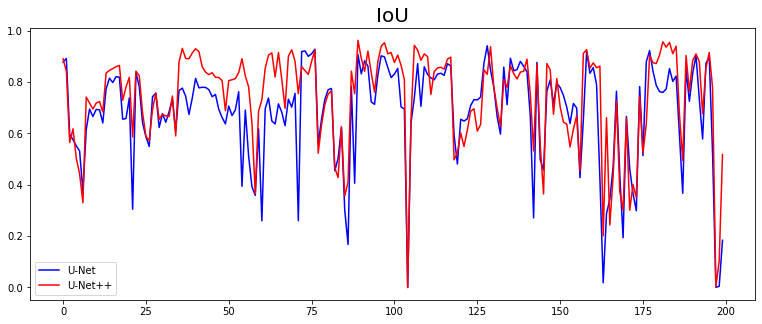

In [94]:
plt.figure(figsize=(13,5))

plt.plot(unet_iou, 'b')
plt.plot(unet_pp_iou, 'r')

plt.title('IoU', fontsize=20)
plt.legend(['U-Net', 'U-Net++'])
plt.show()

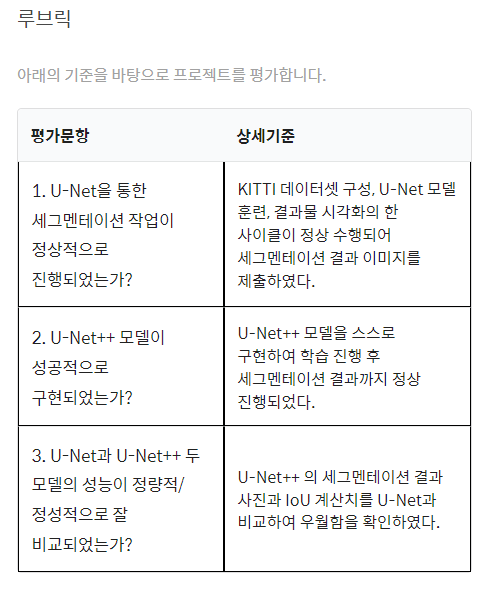

**회고**

전반적으로 U-Net++가 더 우월함을 정성적으로 정량적으로 확인할수 있었다.

논문을 따로 보지는 않고 파이토치로 구현된 잘 정리된 블로그를 보면서 공부를 하였는데, 아직까지 이해도가 높은것 같지는 않다. 특히 수식적인 부분이나 밑바닥부터의 이해가 이루어지지 않았는데, 이 부분은 아이펠과정이 끝나고 정리하며 해볼 예정이다.